In [1]:
import sys; sys.path.append('..') # add project root to the python path

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.part2.monte_carlo import ExactMCAgent, MCAgent, run_episode
from src.common.gridworld import GridworldEnv
from src.common.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [3]:
nx, ny = 4, 4
env = GridworldEnv([ny, nx])

## Monte-carlo '에이전트' 초기화하기

`MCAgent` 는 learning rate를 사용하는 버전의 Monte-carlo 정책평가를 수행합니다. MC policy evaluation은 다음과 같은 수식으로 행동 가치함수를 추산합니다.

$$Q(s,a) \leftarrow Q(s,a) + \alpha (G(s,a) - Q(s,a))$$

여기서, $G(s,a)$ 는 상태-행동 $(s,a)$의 리턴 추산치의 합. $\alpha$ 학습률. 우리가 평가하려는 정책은 행동 가치함수 $Q(s,a)$ 에 대한 '$\epsilon$-탐욕적 정책' 이라고 생각해보겠습니다. 이제 한번 파이썬 구현체를 살펴보도록 할까요?

In [4]:
mc_agent = MCAgent(gamma=1.0,
                   lr=1e-3,
                   num_states=nx * ny,
                   num_actions=4,
                   epsilon=1.0) # epsilon=1.0? -> 모든 행동을 같은 확률로 하는 정책 

### 실험을 도와줄 Helper 함수; `run_episode()`

앞서 __Monte-carlo 정책평가__ 실습에서 살펴봤듯, MC 기법은 하나의 에피소드가 끝난 후, 행동 가치함수를 업데이트 할 수 있습니다.
즉, 모든 업데이트는 episodic 하게 이루어지게 되겠죠? 이번 실습에서도 앞선 실습과 유사한 방법을 활용해서 $Q(s,a)$를 추산해보도록 할까요?

```python
def run_episode(env, agent, timeout=1000):
    env.reset()
    states = []
    actions = []
    rewards = []

    i = 0
    timeouted = False
    while True:
        state = env.s
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        if done:
            break
        else:
            i += 1
            if i >= timeout:
                timeouted = True
                break

    if not timeouted:
        episode = (states, actions, rewards)
        agent.update(episode)
```

> `timeout` 은 MC 에이전트가 학습 중에 정책이 잘못 학습되어 하나의 에피소드가 끝나지 않을 경우에, 강제로 에피소드를 종료하는 장치입니다.

In [5]:
for _ in range(5000):
    run_episode(env, mc_agent)

### `MCAgent.get_action()` 과 `MCAgent._policy_q` 살펴보기

수업에서 사용하는 `MCAgent`는 `MCAgent.q` $Q(s,a)$ 와 $\pi(a|s)$를 생성하기 위해 사용하는 `MCAgent._policy_q`를 __독립적으로__ 가지고 있습니다. 일반적인 구현에서는 여태까지 알고 있는 가장 최신의 $Q(s,a)$ 를 정책을 생성하기 위해 사용합니다. 하지만, 저희 예제는 각각의 policy evaluation 과정과 policy improvment 과정을 명확히 분리해서 보여주기 위해 두개의 개념을 분리했습니다. 이에 따라서, `MCAgent.get_action`은 `MCAgent._policy_q`을 활용해서 $\pi(a|s)$를 생성합니다.

```python
class ExactMCAgent:
    """
    The exact Monte-Carlo agent.
    This agents performs value update as follows:
    V(s) <- s(s) / n(s)
    Q(s,a) <- s(s,a) / n(s,a)
    """

    def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 epsilon: float):
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.epsilon = epsilon

        self._eps = 1e-10  # for stable computation of V and Q. NOT the one for e-greedy!
        ...
        
        # Initialize "policy Q"
        # "policy Q" is the one used for policy generation.
        self._policy_q = None
        self.reset_policy()
        ...
    
    def reset_policy(self):
        self._policy_q = np.zeros(shape=(self.num_states, self.num_actions))
        
    def get_action(self, state):
        prob = np.random.uniform(0.0, 1.0, 1)
        # e-greedy policy over Q
        if prob <= self.epsilon:  # random
            action = np.random.choice(range(self.num_actions))
        else:  # greedy
            action = self._policy_q[state, :].argmax()
        return action
    
    def improve_policy(self):
        self._policy_q = self.q.copy()
        self.reset_values()
        self.reset_statistics()
        
    def reset_statistics(self):
        self.n_v = np.zeros(shape=self.num_states)
        self.s_v = np.zeros(shape=self.num_states)

        self.n_q = np.zeros(shape=(self.num_states, self.num_actions))
        self.s_q = np.zeros(shape=(self.num_states, self.num_actions))

    def reset_values(self):
        self.v = np.zeros(shape=self.num_states)
        self.q = np.zeros(shape=(self.num_states, self.num_actions))

```

In [6]:
mc_agent.improve_policy()

In [7]:
mc_agent._policy_q

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [ -9.68749471, -14.2719148 , -12.16379596,  -0.65164296],
       [-17.25182546, -18.33267138, -16.35424   , -11.78354527],
       [-17.82707884, -18.37002714, -16.91165181, -17.23215837],
       [ -0.67553022, -13.23952411, -14.86259367, -11.53321592],
       [-11.51242539, -16.11382567, -15.48551789, -12.05839818],
       [-16.30312593, -16.27465131, -15.16991164, -15.49493358],
       [-17.91287138, -16.20552382, -11.68654474, -16.6017639 ],
       [-12.08264006, -17.0142515 , -18.25426251, -16.99086551],
       [-15.17358097, -15.32707571, -17.19774298, -16.38246195],
       [-15.64742991, -11.4508426 , -10.66749208, -16.1678177 ],
       [-14.41782112, -11.13612464,  -0.66160515, -12.2713501 ],
       [-17.6451378 , -17.7588519 , -19.34264285, -18.39622414],
       [-17.20159311, -12.00456647, -16.45305441, -18.68973601],
       [-12.27575474,  -0.68480929,  -9.47430587, -13.90828893],
       [  0.        ,   0

## 추산된 상태가치함수 $V(s)$ 및 $Q(s,a)$ 확인하기

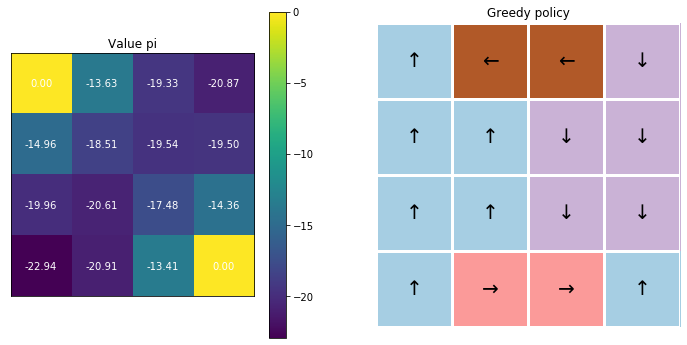

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent.q, nx, ny)
_ = ax[1].set_title("Greedy policy")

In [9]:
import pandas as pd

def highlight_max(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

def visualize_q(q):
    df = pd.DataFrame(q, columns=['up', 'right', 'down', 'left']).T
    df = df.style.apply(highlight_max)
    return df

In [10]:
df = visualize_q(mc_agent.q)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
up,0.000000,-9.687495,-17.251825,-17.827079,-0.675530,-11.512425,-16.303126,-17.912871,-12.082640,-15.173581,-15.647430,-14.417821,-17.645138,-17.201593,-12.275755,0.000000
right,0.000000,-14.271915,-18.332671,-18.370027,-13.239524,-16.113826,-16.274651,-16.205524,-17.014252,-15.327076,-11.450843,-11.136125,-17.758852,-12.004566,-0.684809,0.000000
down,0.000000,-12.163796,-16.354240,-16.911652,-14.862594,-15.485518,-15.169912,-11.686545,-18.254263,-17.197743,-10.667492,-0.661605,-19.342643,-16.453054,-9.474306,0.000000
left,0.000000,-0.651643,-11.783545,-17.232158,-11.533216,-12.058398,-15.494934,-16.601764,-16.990866,-16.382462,-16.167818,-12.271350,-18.396224,-18.689736,-13.908289,0.000000


## Playing with $\epsilon$ !

지금까지는 $\epsilon$-탐욕적 정책에서 $\epsilon=1$인 경우에 대해 정책을 평가했었습니다. 이제 한번 epsilon 을 조금씩 줄여가면서, 최적 정책 및 최적 상태 및 행동 가치함수를 찾아보도록 할까요? 아래의 함수를 활용해서 $\epsilon$을 한번 조정해봅시다.

```python
def decaying_epsilon(self, factor):
    self.epsilon *= factor
```

In [11]:
def decaying_epsilon_and_run(agent, env,
                             decaying_factor:float,
                             n_runs:int = 5000):

    agent.decaying_epsilon(decaying_factor)
    agent.reset_statistics()
    
    print("epsilon : {}".format(agent.epsilon))

    for _ in range(n_runs):
        run_episode(env, agent)

    agent.improve_policy()

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    visualize_value_function(ax[0], agent.v, nx, ny)
    _ = ax[0].set_title("Value pi")
    visualize_policy(ax[1], agent._policy_q, nx, ny)
    _ = ax[1].set_title("Greedy policy")

epsilon : 0.9
epsilon : 0.81
epsilon : 0.08100000000000002
epsilon : 0.008100000000000001
epsilon : 0.0008100000000000002
epsilon : 0.0


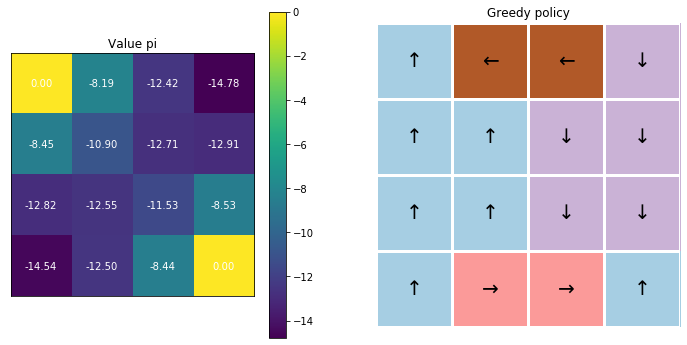

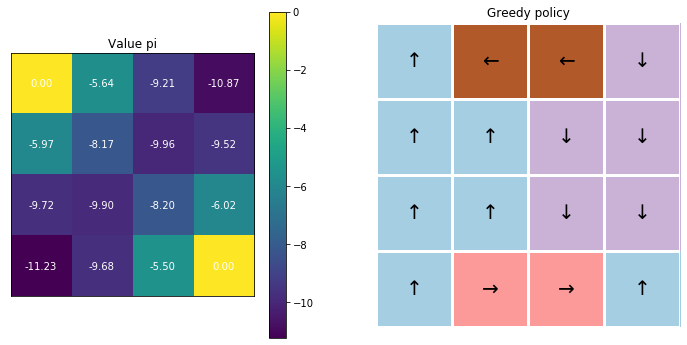

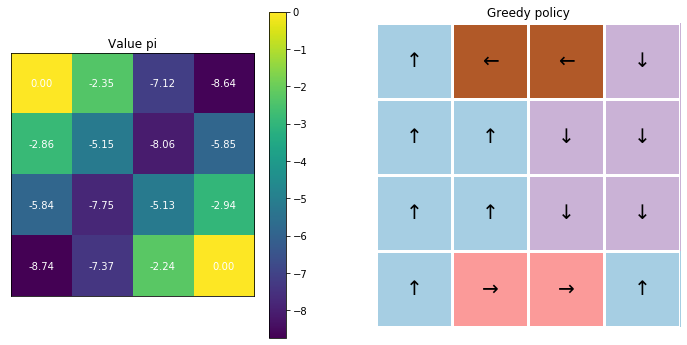

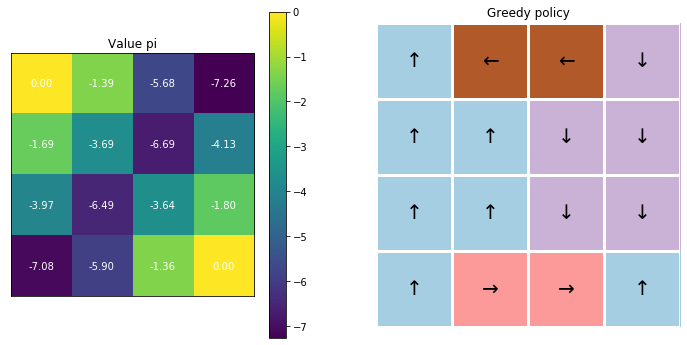

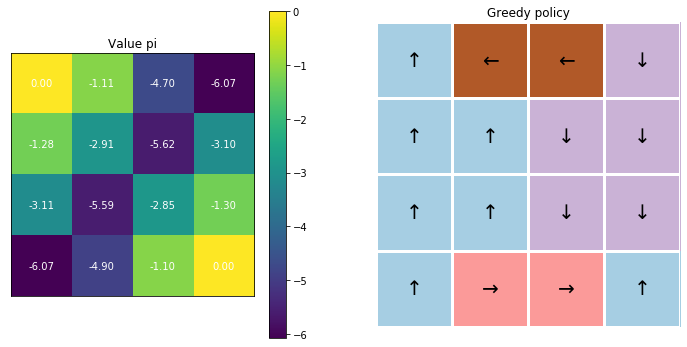

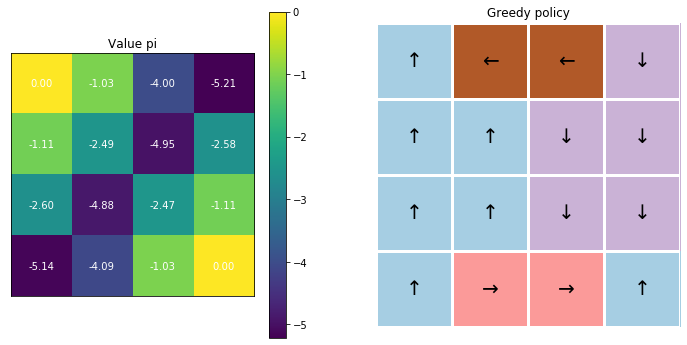

In [12]:
decaying_epsilon_and_run(mc_agent, env, 0.9)
decaying_epsilon_and_run(mc_agent, env, 0.9)
decaying_epsilon_and_run(mc_agent, env, 0.1)
decaying_epsilon_and_run(mc_agent, env, 0.1)
decaying_epsilon_and_run(mc_agent, env, 0.1)
decaying_epsilon_and_run(mc_agent, env, 0.0)

### $\epsilon$ decaying 이전에 이미 최적 정책함수를 찾았던거 기억하세요?

In [13]:
mc_agent_non_decay = MCAgent(gamma=1.0,
                             lr=1e-3,
                             num_states=nx * ny,
                             num_actions=4,
                             epsilon=1.0) # epsilon=1.0? -> 모든 행동을 같은 확률로 하는 정책 

In [14]:
for _ in range(5000):
    run_episode(env, mc_agent_non_decay)
    
mc_agent_non_decay.improve_policy()

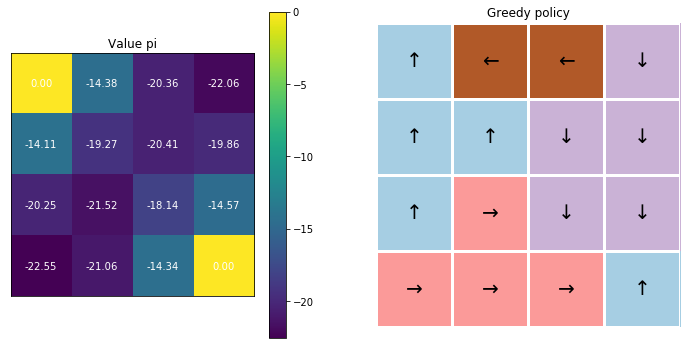

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent_non_decay.v, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], mc_agent_non_decay.q, nx, ny)
_ = ax[1].set_title("Greedy policy")

## 최적 정책함수 $\pi^{*}(a|s)$ 와 MC 기법을 활용해서 최적 가치함수 추정하기

MC agent는 랜덤 정책으로부터 최적 정책을 만드는 $Q(s,a)$를 찾을 수 있었습니다. 그렇다면 그 $Q(s,a)$로 만들어진 
greedy 정책을 가지고 Monte-carlo 정책평가를 수행하면 최적 정책함수 $V^{*}(s)$를 찾을 수 있을까요? 당연히 가능하겠지만, 간단한 실험을 통해서
확인해볼까요?

epsilon : 0.0


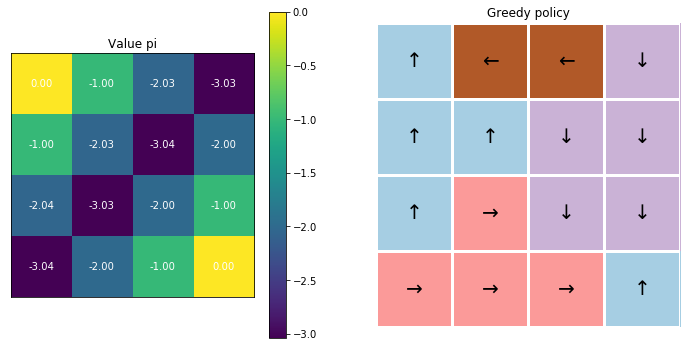

In [16]:
decaying_epsilon_and_run(mc_agent_non_decay, env, 0.0, 100000)

## 성급한 decaying

수업에서도 다뤘듯, $\epsilon$을 decaying 할 때는 적당한 schedule 을 사용하는 것이 필요합니다. 
만약 그렇게 못하면, `MCAgent`는 최적 정책을 찾지 못하게 되겠죠.

한번 간단한 실험을 진행해볼까요? 극단적인 경우로, $\epsilon$ 으로 `MCAgent`을 하나 만들어봅시다. 

In [17]:
greedy_mc_agent = MCAgent(gamma=1.0,
                          lr=1e-3,
                          num_states=nx * ny,
                          num_actions=4,
                          epsilon=0.0)

In [ ]:
# 조금 오래 걸립니다. 실행 중간에 멈추지 마세요 :)
# 많은 경우는 timeout이 걸릴때까지 episode를 진행하기 때문입니다.

decaying_epsilon_and_run(greedy_mc_agent, env, 0.0, 5000) 

epsilon : 0.0
